# 01_data_cleaning

In [107]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pickle

# stops the warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

##### Load in data

In [109]:
df = pd.read_csv('vehicles.csv')

In [110]:
pd.set_option('display.max_rows', 20)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

### I. Remove the columns discussed at the end of 00_eda

In [112]:
cols_to_remove = ['VIN', 'county', 'description', 'id', 'image_url', 'region_url', 'size', 'url']

df = df.drop(cols_to_remove, axis = 1)

In [113]:
# Move the 'price' column to the front and sort the remaining columns in alphabetical order
df = df[['price'] + sorted(list(set(df.columns) - {'price'}))]

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   condition     252776 non-null  object 
 2   cylinders     249202 non-null  object 
 3   drive         296313 non-null  object 
 4   fuel          423867 non-null  object 
 5   lat           420331 non-null  float64
 6   long          420331 non-null  float64
 7   manufacturer  409234 non-null  object 
 8   model         421603 non-null  object 
 9   odometer      422480 non-null  float64
 10  paint_color   296677 non-null  object 
 11  posting_date  426812 non-null  object 
 12  region        426880 non-null  object 
 13  state         426880 non-null  object 
 14  title_status  418638 non-null  object 
 15  transmission  424324 non-null  object 
 16  type          334022 non-null  object 
 17  year          425675 non-null  float64
dtypes: f

### II. Convert posting_date to datetime

In [115]:
df['posting_date']

0                              NaN
1                              NaN
2                              NaN
3                              NaN
4                              NaN
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 426880, dtype: object

In [116]:
df['posting_date'] = pd.to_datetime(df['posting_date'].str[:10], format='%Y-%m-%d')

In [117]:
df['posting_date']

0               NaT
1               NaT
2               NaT
3               NaT
4               NaT
            ...    
426875   2021-04-04
426876   2021-04-04
426877   2021-04-04
426878   2021-04-04
426879   2021-04-04
Name: posting_date, Length: 426880, dtype: datetime64[ns]

### III. Dealing With Outliers

##### Starting off, I'm just going to remove all observations with >$250K price

In [118]:
# Count the number of observations with a 'price' over 250,000
n_over_250k = (df['price'] > 250000).sum()

# Calculate the percent of observations with a 'price' over 200,000
pct_over_250k = n_over_250k / len(df) * 100

# Remove the observations with a 'price' over 200,000
df = df[df['price'] <= 250000]

# Display the results
print(f"Number of observations with a 'price' over 200,000: {n_over_250k}")
print(f"Percent of observations with a 'price' over 200,000: {pct_over_250k:.2f}%")
print("Observations with a 'price' over 200,000 removed.")

Number of observations with a 'price' over 200,000: 95
Percent of observations with a 'price' over 200,000: 0.02%
Observations with a 'price' over 200,000 removed.


##### Will remove rows with z-score >3; let's keep track of how many this includes by col though

In [119]:
# select only the numeric columns
numeric_cols = df.select_dtypes(include=[float, int]).columns

# calculate the z-score for each value in the numeric columns of the dataframe
z_scores = ((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()).abs()

# create a boolean mask for rows with any z-score greater than 3
mask = (z_scores > 3).any(axis=1)

# remove the rows with outlier z-scores from the dataframe
df_clean = df[~mask]

In [120]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405444 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         405444 non-null  int64         
 1   condition     241985 non-null  object        
 2   cylinders     235846 non-null  object        
 3   drive         281551 non-null  object        
 4   fuel          402609 non-null  object        
 5   lat           398942 non-null  float64       
 6   long          398942 non-null  float64       
 7   manufacturer  390613 non-null  object        
 8   model         401329 non-null  object        
 9   odometer      401152 non-null  float64       
 10  paint_color   282270 non-null  object        
 11  posting_date  405376 non-null  datetime64[ns]
 12  region        405444 non-null  object        
 13  state         405444 non-null  object        
 14  title_status  397456 non-null  object        
 15  transmission  403

In [121]:
print(f'There were {len(df) - len(df_clean)} outliers out of {len(df) - n_over_250k} observations removed from the dataset')

There were 21341 outliers out of 426690 observations removed from the dataset


### IV. Impute Missing Data

##### Output missingness by col

In [122]:
# Calculate the percent of missing values by column
missing_pct = df_clean.isna().mean().round(4) * 100

# Create a summary table
summary_table = pd.DataFrame({'Column Name': df.columns, 'Percent Missing': missing_pct})

# Sort the summary table by percent missing values in descending order
summary_table = summary_table.sort_values(by='Percent Missing', ascending=False)

# Display the summary table
print(summary_table)

               Column Name  Percent Missing
cylinders        cylinders            41.83
condition        condition            40.32
drive                drive            30.56
paint_color    paint_color            30.38
type                  type            21.31
manufacturer  manufacturer             3.66
title_status  title_status             1.97
lat                    lat             1.60
long                  long             1.60
odometer          odometer             1.06
model                model             1.01
fuel                  fuel             0.70
transmission  transmission             0.59
year                  year             0.25
posting_date  posting_date             0.02
state                state             0.00
region              region             0.00
price                price             0.00


##### Since manufacturer and model are so crucial to this project, I will just remove all rows that are missing for those. Besides that, for cols <5% missing data, impute mode on categoricals and median on numerics

In [123]:
# drop rows with missing data in 'manufacturer' and 'model' columns
df_clean.dropna(subset=['manufacturer', 'model'], inplace=True)

In [124]:
# loop over columns and check if less than 5% of values are missing
for col in df_clean.columns:
    if df_clean[col].isna().sum() / len(df_clean) < 0.05:
        if df_clean[col].dtype == 'object':
            # impute missing categorical values with mode
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
        else:
            # impute missing numeric values with median
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

In [125]:
# Calculate the percent of missing values by column
missing_pct = round(df_clean.isna().mean().round(6) * 100, 15)

# Create a summary table
summary_table = pd.DataFrame({'Column Name': df.columns, 'Percent Missing': missing_pct})

# Sort the summary table by percent missing values in descending order
summary_table = summary_table.sort_values(by='Percent Missing', ascending=False)

# Display the summary table
print(summary_table)

               Column Name  Percent Missing
cylinders        cylinders          41.4593
condition        condition          40.1778
drive                drive          29.9715
paint_color    paint_color          29.9702
type                  type          20.5074
price                price           0.0000
posting_date  posting_date           0.0000
transmission  transmission           0.0000
title_status  title_status           0.0000
state                state           0.0000
region              region           0.0000
odometer          odometer           0.0000
model                model           0.0000
manufacturer  manufacturer           0.0000
long                  long           0.0000
lat                    lat           0.0000
fuel                  fuel           0.0000
year                  year           0.0000


##### For the rest of the cols, I will just impute a new level called missing

In [126]:
# fill null values with "missing"
df_clean.fillna("missing", inplace=True)

# Calculate the percent of missing values by column
missing_pct = round(df_clean.isna().mean().round(6) * 100, 15)

# Create a summary table
summary_table = pd.DataFrame({'Column Name': df_clean.columns, 'Percent Missing': missing_pct})

# Sort the summary table by percent missing values in descending order
summary_table = summary_table.sort_values(by='Percent Missing', ascending=False)

# Display the summary table
print(summary_table)

               Column Name  Percent Missing
price                price              0.0
condition        condition              0.0
type                  type              0.0
transmission  transmission              0.0
title_status  title_status              0.0
state                state              0.0
region              region              0.0
posting_date  posting_date              0.0
paint_color    paint_color              0.0
odometer          odometer              0.0
model                model              0.0
manufacturer  manufacturer              0.0
long                  long              0.0
lat                    lat              0.0
fuel                  fuel              0.0
drive                drive              0.0
cylinders        cylinders              0.0
year                  year              0.0


In [127]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386567 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         386567 non-null  int64         
 1   condition     386567 non-null  object        
 2   cylinders     386567 non-null  object        
 3   drive         386567 non-null  object        
 4   fuel          386567 non-null  object        
 5   lat           386567 non-null  float64       
 6   long          386567 non-null  float64       
 7   manufacturer  386567 non-null  object        
 8   model         386567 non-null  object        
 9   odometer      386567 non-null  float64       
 10  paint_color   386567 non-null  object        
 11  posting_date  386567 non-null  datetime64[ns]
 12  region        386567 non-null  object        
 13  state         386567 non-null  object        
 14  title_status  386567 non-null  object        
 15  transmission  38

##### Make EDA plots with the new data

In [128]:
import seaborn as sns

def eda_plots(data):
    """
    Performs EDA for numeric and categorical columns in the given pandas DataFrame.
    """

    # Set default figure size for all charts
    plt.rcParams['figure.figsize'] = [6, 2]

    # Perform EDA for numeric and categorical columns
    for col in data.columns:
        if data[col].dtype == 'float64' or data[col].dtype == 'int64':


            # Print column name, median, quartiles, min, and max
            print()
            print('-----------------------------------------------------------------------------')
            print()
            print('Column Name:', col, '(Numeric)')
            print('Median:', data[col].median())
            print('Q1:', data[col].quantile(0.25))
            print('Q3:', data[col].quantile(0.75))
            print('Min:', data[col].min())
            print('Max:', data[col].max())
            print('Percent missing:', data[col].isna().mean().round(2) * 100)

            # Plot the distribution and average price on separate y axes
            fig, ax1 = plt.subplots()

            ax1.hist(data[col], bins=30, alpha=0.5, color='b')
            ax1.set_xlabel(col)
            ax1.set_ylabel('Count')

            ax1.tick_params(axis='x', labelrotation=90) # Rotate x-axis labels
            ax1.tick_params(axis='y', labelrotation=0) # Rotate y-axis labels
            ax1.ticklabel_format(style='plain', axis='y') # Change y-axis format to normal numbers
            ax1.xaxis.set_major_formatter('{:.0f}'.format) # Change x-axis format to normal numbers

            ax2 = ax1.twinx()
            avg_price = data.groupby(col)['price'].mean()
            ax2.plot(avg_price.index, avg_price.values, '.', color='r')
            ax2.set_ylabel('Price')
            ax2.tick_params(axis='y', labelrotation=0) # Rotate y-axis labels
            ax2.ticklabel_format(style='plain', axis='y') # Change y-axis format to normal numbers
            ax2.yaxis.set_major_formatter('${x:,.0f}') # Add dollar sign to y-axis labels

            plt.show()

        elif data[col].dtype == 'object':
            # Print column name and whether it is categorical or numeric
            print()
            print('-----------------------------------------------------------------------------')
            print()
            
            
            if data[col].nunique() > 75:
                print('Column Name:', col, '(Categorical - top 5 most common)')
                print(data[col].value_counts().head(5))
                print('Number of Unique Values:', data[col].nunique())
                print('Percent missing:', data[col].isna().mean().round(2) * 100)
            else:
                print('Column Name:', col, '(Categorical)')
                print('Number of Unique Values:', data[col].nunique())
                print('Percent missing:', data[col].isna().mean().round(2) * 100)


                # create a figure with a single subplot
                fig, ax = plt.subplots(figsize=(6, 2))

                # plot the boxplot
                sns.boxplot(x=col, y='price', data=data, ax=ax)
                ax.set_xlabel('col')
                ax.set_ylabel('Price')
                ax.tick_params(axis='x', labelrotation=90) # Rotate x-axis labels
                ax.yaxis.set_major_formatter('${x:,.0f}') # Add dollar sign to y-axis labels

                # plot the histogram on top of the boxplot
                sns.histplot(x=col, data=data, ax=ax, bins=5, kde=False, color='gray', alpha=0.5)

                plt.show()


-----------------------------------------------------------------------------

Column Name: price (Numeric)
Median: 13790.0
Q1: 5950.0
Q3: 25990.0
Min: 0
Max: 63750
Percent missing: 0.0


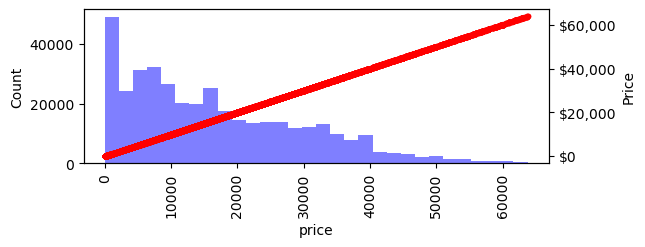


-----------------------------------------------------------------------------

Column Name: condition (Categorical)
Number of Unique Values: 7
Percent missing: 0.0


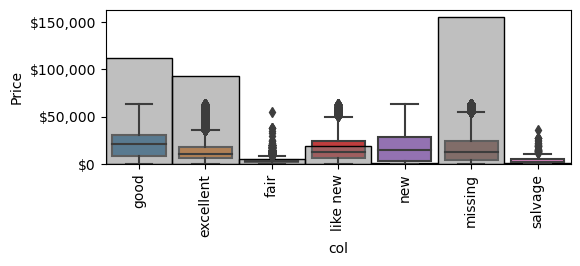


-----------------------------------------------------------------------------

Column Name: cylinders (Categorical)
Number of Unique Values: 9
Percent missing: 0.0


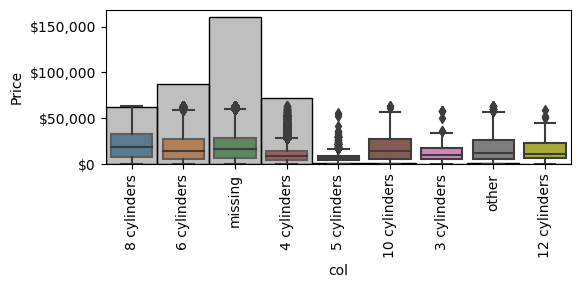


-----------------------------------------------------------------------------

Column Name: drive (Categorical)
Number of Unique Values: 4
Percent missing: 0.0


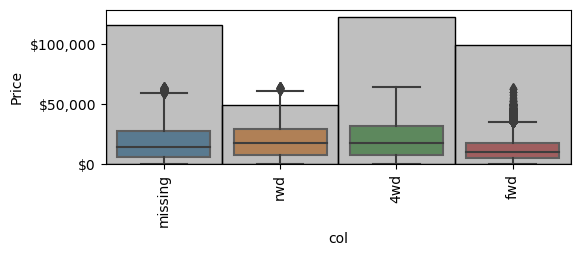


-----------------------------------------------------------------------------

Column Name: fuel (Categorical)
Number of Unique Values: 5
Percent missing: 0.0


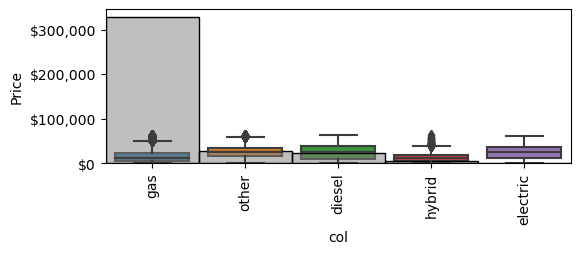


-----------------------------------------------------------------------------

Column Name: lat (Numeric)
Median: 39.1501
Q1: 34.9300255
Q3: 42.316052
Min: 21.245361
Max: 55.5526
Percent missing: 0.0


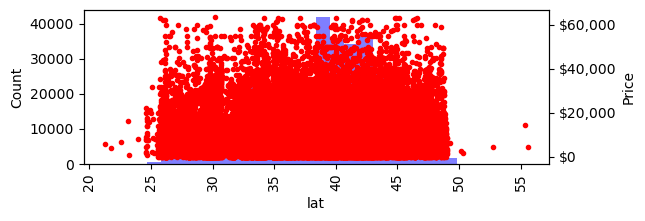


-----------------------------------------------------------------------------

Column Name: long (Numeric)
Median: -87.9715
Q1: -108.576627
Q3: -80.83
Min: -133.0555
Max: -61.944582
Percent missing: 0.0


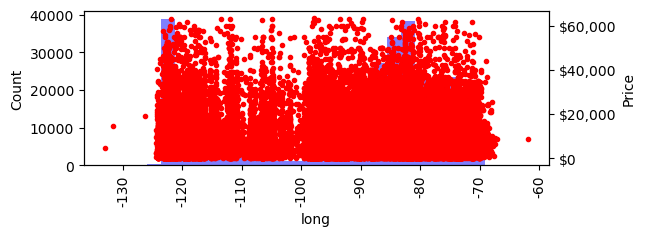


-----------------------------------------------------------------------------

Column Name: manufacturer (Categorical)
Number of Unique Values: 41
Percent missing: 0.0


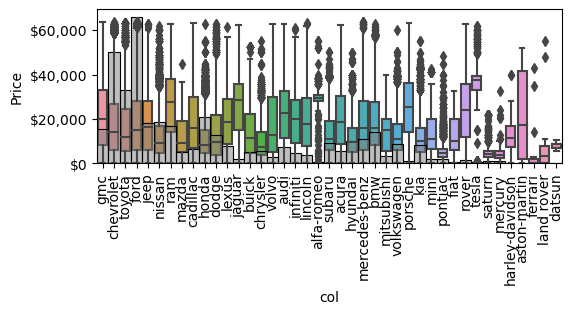


-----------------------------------------------------------------------------

Column Name: model (Categorical - top 5 most common)
f-150             7733
silverado 1500    5028
1500              4118
camry             3096
accord            2921
Name: model, dtype: int64
Number of Unique Values: 21934
Percent missing: 0.0

-----------------------------------------------------------------------------

Column Name: odometer (Numeric)
Median: 87934.0
Q1: 40242.5
Q3: 134000.0
Min: 0.0
Max: 732014.0
Percent missing: 0.0


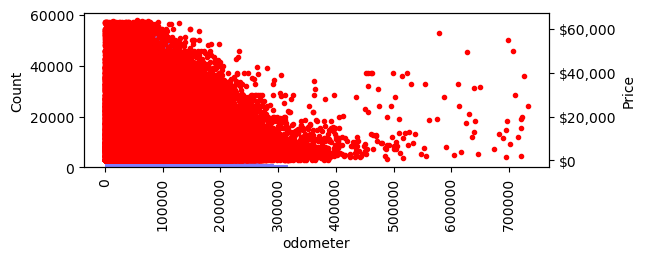


-----------------------------------------------------------------------------

Column Name: paint_color (Categorical)
Number of Unique Values: 13
Percent missing: 0.0


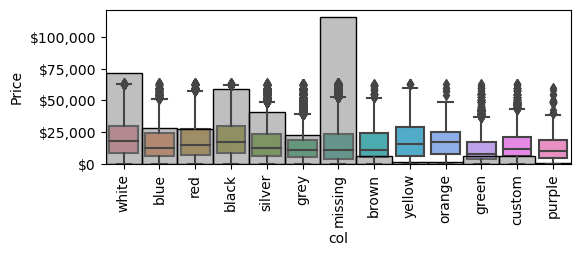


-----------------------------------------------------------------------------

Column Name: region (Categorical - top 5 most common)
columbus          3328
jacksonville      3323
salem             2843
stockton          2833
washington, DC    2829
Name: region, dtype: int64
Number of Unique Values: 404
Percent missing: 0.0

-----------------------------------------------------------------------------

Column Name: state (Categorical)
Number of Unique Values: 51
Percent missing: 0.0


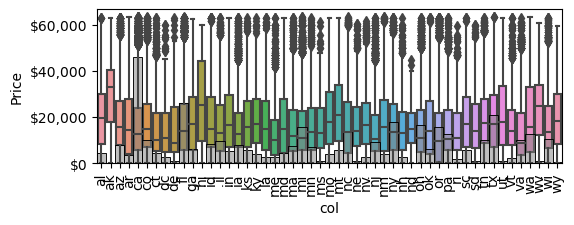


-----------------------------------------------------------------------------

Column Name: title_status (Categorical)
Number of Unique Values: 6
Percent missing: 0.0


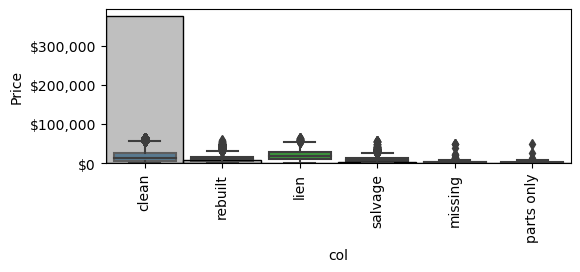


-----------------------------------------------------------------------------

Column Name: transmission (Categorical)
Number of Unique Values: 3
Percent missing: 0.0


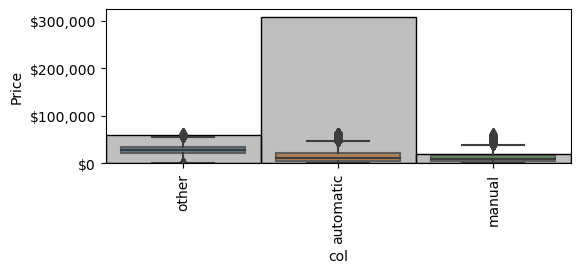


-----------------------------------------------------------------------------

Column Name: type (Categorical)
Number of Unique Values: 14
Percent missing: 0.0


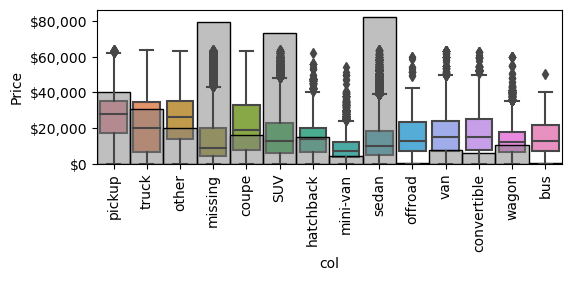


-----------------------------------------------------------------------------

Column Name: year (Numeric)
Median: 2014.0
Q1: 2009.0
Q3: 2017.0
Min: 1983.0
Max: 2022.0
Percent missing: 0.0


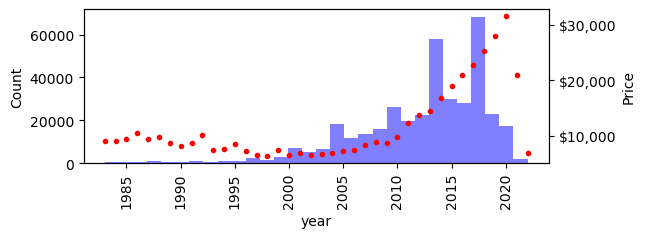

In [129]:
eda_plots(df_clean)

### V. Remove Rows Where Latitude and Longitude are not in the USA

In [130]:
# Count number of rows before filtering
num_rows_before = len(df_clean)

# Filter df_clean DataFrame to only include rows with lat/long in USA
df_clean = df_clean[(df_clean['lat'] >= min_lat) & (df_clean['lat'] <= max_lat)
                    & (df_clean['long'] >= min_lon) & (df_clean['long'] <= max_lon)]

# Count number of rows after filtering
num_rows_removed = num_rows_before - len(df_clean)

# Output filtered df_clean DataFrame and number of rows removed
print(f"{num_rows_removed} rows removed.")

63 rows removed.


### VI. Dealing with the 'model' feature

In [131]:
pd.set_option('display.max_rows', 200)
df_clean['model'].value_counts()

f-150                   7732
silverado 1500          5028
1500                    4118
camry                   3096
accord                  2917
                        ... 
pathfinder xe              1
liberty sport 4×4          1
tl 3.2 premium sedan       1
1500 reg cab               1
gand wagoneer              1
Name: model, Length: 21928, dtype: int64

##### Transform everything properly

In [142]:
df_clean['model'].loc[df_clean['model'].str.contains('f-150')] = 'Ford F-150'
df_clean['model'].loc[df_clean['model'].str.contains('f150')] = 'Ford F-150'
df_clean['model'].loc[df_clean['model'].str.contains('Ford F-150')] = 'Ford F-150'
df_clean['model'].loc[df_clean['model'].str.contains('silverado')] = 'Chevrolet Silverado'
df_clean['model'][df_clean['model'] == '1500'] = 'Ram 1500'
df_clean['model'][df_clean['model'] == '2500'] = 'Ram 2500'
df_clean['model'].loc[df_clean['model'].str.contains('camry')] = 'Toyota Camry'
df_clean['model'].loc[df_clean['model'].str.contains('tacoma')] = 'Toyota Tacoma'
df_clean['model'].loc[df_clean['model'].str.contains('accord')] = 'Honda Accord'
df_clean['model'].loc[df_clean['model'].str.contains('wrangler ')] = 'Jeep Wrangler'
df_clean['model'].loc[df_clean['model'].str.contains('escape ')] = 'Ford Escape'
df_clean['model'].loc[df_clean['model'].str.contains('civic')] = 'Honda Civic'
df_clean['model'].loc[df_clean['model'].str.contains('altima')] = 'Nissan Altima'
df_clean['model'].loc[df_clean['model'].str.contains('cherokee')] = 'Jeep Grand Cherokee'
df_clean['model'].loc[df_clean['model'].str.contains('explorer')] = 'Ford Explorer'
df_clean['model'].loc[df_clean['model'].str.contains('corolla')] = 'Toyota Corolla'
df_clean['model'].loc[df_clean['model'].str.contains('escape')] = 'Ford Escape'
df_clean['model'].loc[df_clean['model'].str.contains('wrangler')] = 'Jeep Wrangler'
df_clean['model'].loc[df_clean['model'].str.contains('mustang')] = 'Ford Mustang'
df_clean['model'].loc[df_clean['model'].str.contains('cr-v')] = 'Honda CR-V'
df_clean['model'].loc[df_clean['model'].str.contains('fusion')] = 'Ford Fusion'
df_clean['model'].loc[df_clean['model'].str.contains('equinox')] = 'Chevrolet Equinox'
df_clean['model'].loc[df_clean['model'].str.contains('f-250')] = 'Ford F-250'
df_clean['model'].loc[df_clean['model'].str.contains('rav4')] = 'Toyota Rav4'
df_clean['model'].loc[df_clean['model'].str.contains('sierra')] = 'GMC Sierra'
df_clean['model'].loc[df_clean['model'].str.contains('tahoe')] = 'Chevrolet Tahoe'
df_clean['model'].loc[df_clean['model'].str.contains('tundra')] = 'Toyota Tundra'
df_clean['model'].loc[df_clean['model'].str.contains('focus')] = 'Ford Focus'
df_clean['model'].loc[df_clean['model'].str.contains('charger')] = 'Dodge Charger'
df_clean['model'].loc[df_clean['model'].str.contains('sonata')] = 'Hyundai Sonata'
df_clean['model'].loc[df_clean['model'].str.contains('impala')] = 'Chevrolet Impala'
df_clean['model'].loc[df_clean['model'].str.contains('malibu')] = 'Chevrolet Malibu'
df_clean['model'].loc[df_clean['model'].str.contains('cruze')] = 'Chevrolet Cruze'
df_clean['model'].loc[df_clean['model'].str.contains('elantra')] = 'Hyundai Elantra'
df_clean['model'].loc[df_clean['model'].str.contains('prius')] = 'Toyota Prius'
df_clean['model'].loc[df_clean['model'].str.contains('grand caravan')] = 'Jeep Grand Caravan'
df_clean['model'].loc[df_clean['model'].str.contains('sentra')] = 'Nissan Sentra'
df_clean['model'].loc[df_clean['model'].str.contains('rogue')] = 'Nissan Rogue'
df_clean['model'].loc[df_clean['model'].str.contains('jetta')] = 'Volkswagen Jetta'
df_clean['model'].loc[df_clean['model'].str.contains('odyssey')] = 'Honda Odyssey'
df_clean['model'].loc[df_clean['model'].str.contains('corvette')] = 'Chevrolet Corvette'
df_clean['model'].loc[df_clean['model'].str.contains('edge')] = 'Ford Edge'
df_clean['model'].loc[df_clean['model'].str.contains('sienna')] = 'Toyota Sienna'
df_clean['model'].loc[df_clean['model'].str.contains('3500')] = 'Ram 3500'
df_clean['model'].loc[df_clean['model'].str.contains('f-350')] = 'Ford F-350'
df_clean['model'].loc[df_clean['model'].str.contains('suburban')] = 'Chevrolet Suburban'
df_clean['model'].loc[df_clean['model'].str.contains('4runner')] = 'Toyota 4Runner'
df_clean['model'].loc[df_clean['model'].str.contains('outback')] = 'Subaru Outback'
df_clean['model'].loc[df_clean['model'].str.contains('pilot')] = 'Honda Pilot'
df_clean['model'].loc[df_clean['model'].str.contains('soul')] = 'Kia Soul'
df_clean['model'].loc[df_clean['model'].str.contains('highlander')] = 'Toyota Highlander'
df_clean['model'].loc[df_clean['model'].str.contains('3 series')] = 'BMW 3 Series'
df_clean['model'].loc[df_clean['model'].str.contains('forester')] = 'Subaru Forester'
df_clean['model'].loc[df_clean['model'].str.contains('challenger')] = 'Dodge Challenger'
df_clean['model'].loc[df_clean['model'].str.contains('expedition')] = 'Ford Expedition'
df_clean['model'].loc[df_clean['model'].str.contains('camaro')] = 'Chevrolet Camaro'
df_clean['model'].loc[df_clean['model'].str.contains('5 series')] = 'BMW 5 Series'
df_clean['model'].loc[df_clean['model'].str.contains('c-class')] = 'Mercedes-Benz C-Class'
df_clean['model'].loc[df_clean['model'].str.contains('colorado')] = 'Chevrolet Colorado'
df_clean['model'].loc[df_clean['model'].str.contains('ranger')] = 'Ford Ranger'
df_clean['model'].loc[df_clean['model'].str.contains('taurus')] = 'Ford Taurus'
df_clean['model'].loc[df_clean['model'].str.contains('x5')] = 'BMW X5'
df_clean['model'][df_clean['model'] == '200'] = 'Chrysler 200'
df_clean['model'].loc[df_clean['model'].str.contains('e-class')] = 'Mercedes-Benz E-Class'
df_clean['model'].loc[df_clean['model'].str.contains('optima')] = 'Kia Optima'
df_clean['model'].loc[df_clean['model'].str.contains('versa')] = 'Nissan Versa'
df_clean['model'].loc[df_clean['model'].str.contains('maxima')] = 'Nissan Maxima'
df_clean['model'].loc[df_clean['model'].str.contains('traverse')] = 'Chevrolet Traverse'
df_clean['model'].loc[df_clean['model'].str.contains('santa fe')] = 'Hyundai Santa Fe'
df_clean['model'].loc[df_clean['model'].str.contains('pathfinder')] = 'Nissan Pathfinder'
df_clean['model'].loc[df_clean['model'].str.contains('compass')] = 'Jeep Compass'
df_clean['model'].loc[df_clean['model'].str.contains('yukon')] = 'GMC Yukon'
df_clean['model'].loc[df_clean['model'].str.contains('sorento')] = 'Kia Sorento'
df_clean['model'].loc[df_clean['model'].str.contains('patriot')] = 'Jeep Patriot'
df_clean['model'].loc[df_clean['model'].str.contains('passat')] = 'Volkswagen Passat'
df_clean['model'].loc[df_clean['model'].str.contains('escalade')] = 'Cadillac Escalade'
df_clean['model'].loc[df_clean['model'].str.contains('liberty')] = 'Jeep Liberty'
df_clean['model'].loc[df_clean['model'].str.contains('mx-5')] = 'Mazda MX-5 Miata'
df_clean['model'].loc[df_clean['model'].str.contains('acadia')] = 'GMC Acadia'
df_clean['model'].loc[df_clean['model'].str.contains('impreza')] = 'Subaru Impreza'
df_clean['model'].loc[df_clean['model'].str.contains('journey')] = 'Dodge Journey'
df_clean['model'].loc[df_clean['model'].str.contains('town & country')] = 'Chrysler Town & Country'
df_clean['model'].loc[df_clean['model'].str.contains('mdx')] = 'Acura MDX'
df_clean['model'].loc[df_clean['model'].str.contains('terrain')] = 'GMC Terrain'
df_clean['model'].loc[df_clean['model'].str.contains('durango')] = 'Dodge Durango'
df_clean['model'][df_clean['model'] == '1500 crew cab big horn'] = 'Ram 1500'
df_clean['model'].loc[df_clean['model'].str.contains('frontier')] = 'Nissan Frontier'
df_clean['model'].loc[df_clean['model'].str.contains('rx 350')] = 'Lexus RX 350'
df_clean['model'].loc[df_clean['model'].str.contains('murano')] = 'Nissan Murano'
df_clean['model'].loc[df_clean['model'].str.contains('enclave')] = 'Buick Enclave'
df_clean['model'].loc[df_clean['model'].str.contains('titan')] = 'Nissan Titan'
df_clean['model'].loc[df_clean['model'].str.contains('a4')] = 'Audi A4'
df_clean['model'].loc[df_clean['model'].str.contains('tucson')] = 'Hyundai Tucson'
df_clean['model'].loc[df_clean['model'].str.contains('legacy')] = 'Subaru Legacy'
df_clean['model'].loc[df_clean['model'].str.contains('s-class')] = 'Mercedes-Benz S-Class'
df_clean['model'].loc[df_clean['model'].str.contains('m-class')] = 'Mercedes-Benz M-Class'
df_clean['model'].loc[df_clean['model'].str.contains('es 350')] = 'Lexus ES 350'
df_clean['model'].loc[df_clean['model'].str.contains('300')] = 'Chrysler 300'
df_clean['model'].loc[df_clean['model'].str.contains('f-550')] = 'Ford F-550'
df_clean['model'].loc[df_clean['model'].str.contains('srx')] = 'Cadillac SRX'
df_clean['model'].loc[df_clean['model'].str.contains('forte')] = 'Kia Forte'
df_clean['model'].loc[df_clean['model'].str.contains('fit')] = 'Honda Fit'
df_clean['model'].loc[df_clean['model'].str.contains('cts')] = 'Cadillac CTS'
df_clean['model'].loc[df_clean['model'].str.contains('avalanche')] = 'Chevrolet Avalanche'
df_clean['model'].loc[df_clean['model'].str.contains('pickup 1500')] = 'Ram 1500'
df_clean['model'][df_clean['model'] == 'tl'] = 'Acura TL'
df_clean['model'][df_clean['model'] == '3'] = 'Mazda3'
df_clean['model'].loc[df_clean['model'].str.contains('x3')] = 'BMW X3'
df_clean['model'].loc[df_clean['model'].str.contains('trailblazer')] = 'Chevrolet Trailblazer'
df_clean['model'].loc[df_clean['model'].str.contains('sportage')] = 'Kia Sportage'
df_clean['model'].loc[df_clean['model'].str.contains('mazda3')] = 'Mazda3'
df_clean['model'].loc[df_clean['model'].str.contains('f250')] = 'Ford F-250'
df_clean['model'].loc[df_clean['model'].str.contains('tiguan')] = 'Volkswagen Tiguan'
df_clean['model'].loc[df_clean['model'].str.contains('fiesta')] = 'Ford Fiesta'
df_clean['model'].loc[df_clean['model'].str.contains('transit')] = 'Ford Transit'
df_clean['model'].loc[df_clean['model'].str.contains('avalon')] = 'Toyota Avalon'
df_clean['model'].loc[df_clean['model'].str.contains('dakota')] = 'Dodge Dakota'
df_clean['model'].loc[df_clean['model'].str.contains('cx-5')] = 'Mazda CX-5'
df_clean['model'].loc[df_clean['model'].str.contains('dart')] = 'Dodge Dart'
df_clean['model'].loc[df_clean['model'].str.contains('renegade')] = 'Jeep Renegade'
df_clean['model'].loc[df_clean['model'].str.contains('xterra')] = 'Nissan Xterra'
df_clean['model'].loc[df_clean['model'].str.contains('express cargo van')] = 'Chevrolet Express Cargo Van'
df_clean['model'].loc[df_clean['model'].str.contains('q5')] = 'Audi Q5'
df_clean['model'].loc[df_clean['model'].str.contains('c-max')] = 'Ford C-Max'
df_clean['model'].loc[df_clean['model'].str.contains('328i')] = 'BMW 3 Series'
df_clean['model'].loc[df_clean['model'].str.contains('fj cruiser')] = 'Toyota FJ Cruiser'
df_clean['model'].loc[df_clean['model'].str.contains('370z')] = 'Nissan 370Z'
df_clean['model'].loc[df_clean['model'].str.contains('beetle')] = 'Volkswagen Beetle'
df_clean['model'].loc[df_clean['model'].str.contains('accent')] = 'Hyundai Accent'
df_clean['model'].loc[df_clean['model'].str.contains('lacrosse')] = 'Buick Lacrosse'
df_clean['model'].loc[df_clean['model'].str.contains('town and country')] = 'Chrysler Town & Country'
df_clean['model'].loc[df_clean['model'].str.contains('veloster')] = 'Hyundai Veloster'
df_clean['model'].loc[df_clean['model'].str.contains('mkz')] = 'Lincoln MKZ'
df_clean['model'].loc[df_clean['model'].str.contains('model 3')] = 'Tesla Model 3'
df_clean['model'].loc[df_clean['model'].str.contains('flex')] = 'Ford Flex'
df_clean['model'].loc[df_clean['model'].str.contains('pickup 2500')] = 'Ram 2500'
df_clean['model'].loc[df_clean['model'].str.contains('mkx')] = 'Lincoln MKX'
df_clean['model'][df_clean['model'] == 'express'] = 'Chevrolet Express Cargo Van'
df_clean['model'].loc[df_clean['model'].str.contains('encore')] = 'Buick Encore'
df_clean['model'].loc[df_clean['model'].str.contains('g6')] = 'Pontiac G6'
df_clean['model'].loc[df_clean['model'].str.contains('f350')] = 'Ford F-350'
df_clean['model'].loc[df_clean['model'].str.contains('1500 ')] = 'Ram 1500'
df_clean['model'].loc[df_clean['model'].str.contains('pt cruiser')] = 'Chrysler PT Cruiser'
df_clean['model'].loc[df_clean['model'].str.contains('4 series')] = 'BMW 4 Series'
df_clean['model'].loc[df_clean['model'].str.contains('avenger')] = 'Dodge Avenger'
df_clean['model'].loc[df_clean['model'].str.contains('gl-')] = 'Mercedes-Benz GL-Class'
df_clean['model'].loc[df_clean['model'].str.contains('sonic')] = 'Chevrolet Sonic'
df_clean['model'].loc[df_clean['model'].str.contains('outlander')] = 'Mitsubishi Outlander'
df_clean['model'].loc[df_clean['model'].str.contains('s60')] = 'Volvo S60'
df_clean['model'].loc[df_clean['model'].str.contains('cx-9')] = 'Mazda CX-9'
df_clean['model'].loc[df_clean['model'].str.contains('rdx')] = 'Acura RDX'
df_clean['model'].loc[df_clean['model'].str.contains('pacifica')] = 'Chrysler Pacifica'
df_clean['model'][df_clean['model'] == 'a6'] = 'Audi A6'
df_clean['model'].loc[df_clean['model'].str.contains('gs 3')] = 'Lexus GS 350'
df_clean['model'].loc[df_clean['model'].str.contains('tsx')] = 'Acura TSX'
df_clean['model'].loc[df_clean['model'].str.contains('golf')] = 'Volkswagen Golf'
df_clean['model'].loc[df_clean['model'].str.contains('grand marquis')] = 'Mercur Grand Marquis'
df_clean['model'].loc[df_clean['model'].str.contains('yaris')] = 'Toyota Yaris'
df_clean['model'].loc[df_clean['model'].str.contains('qx60')] = 'Infiniti QX60'
df_clean['model'].loc[df_clean['model'].str.contains('xc90')] = 'Volvo XC90'
df_clean['model'].loc[df_clean['model'].str.contains('3-series')] = 'BMW 3 Series'
df_clean['model'].loc[df_clean['model'].str.contains('cobalt')] = 'Chevrolet Cobalt'
df_clean['model'].loc[df_clean['model'].str.contains('wrx')] = 'Subaru WRX'
df_clean['model'].loc[df_clean['model'].str.contains('ls 46')] = 'Lexus LS 460'
df_clean['model'].loc[df_clean['model'].str.contains('town car')] = 'Lincoln Town Car'
df_clean['model'][df_clean['model'] == 'sport'] = 'Range Rover Sport'
df_clean['model'][df_clean['model'] == 'ats'] = 'Cadillac ATS'
df_clean['model'].loc[df_clean['model'].str.contains('sequoia')] = 'Toyota Sequoia'
df_clean['model'].loc[df_clean['model'].str.contains('armada')] = 'Nissan Armada'
df_clean['model'].loc[df_clean['model'].str.contains('cooper')] = 'Mini Cooper'
df_clean['model'].loc[df_clean['model'].str.contains('dts')] = 'Cadillac DTS'
df_clean['model'].loc[df_clean['model'].str.contains('econoline')] = 'Ford Econoline Cargo Van'
df_clean['model'].loc[df_clean['model'].str.contains('element')] = 'Honda Element'
df_clean['model'].loc[df_clean['model'].str.contains('gti')] = 'Volkswagen GTI'
df_clean['model'].loc[df_clean['model'].str.contains('navigator')] = 'Lincoln Navigator'
df_clean['model'].loc[df_clean['model'].str.contains('tlx')] = 'Acura TLX'
df_clean['model'].loc[df_clean['model'].str.contains('f-450')] = 'Ford F-450'
df_clean['model'].loc[df_clean['model'].str.contains('vue')] = 'Saturn Vue'
df_clean['model'][df_clean['model'] == 'is'] = 'Lexus IS'
df_clean['model'].loc[df_clean['model'].str.contains('mazda6')] = 'Mazda6'
df_clean['model'].loc[df_clean['model'].str.contains('model s')] = 'Tesla Model S'
df_clean['model'][df_clean['model'] == '500'] = 'Fiat 500'
df_clean['model'].loc[df_clean['model'].str.contains('deville')] = 'Cadillac DeVille'
df_clean['model'][df_clean['model'] == 'rx'] = 'Lexus RX'
df_clean['model'].loc[df_clean['model'].str.contains('g35')] = 'Infiniti G35'
df_clean['model'][df_clean['model'] == 'es'] = 'Lexus ES'
df_clean['model'].loc[df_clean['model'].str.contains('spark')] = 'Chevrolet Spark'
df_clean['model'].loc[df_clean['model'].str.contains('trax')] = 'Chevrolet Trax'
df_clean['model'].loc[df_clean['model'].str.contains('qx80')] = 'Infiniti QX80'
df_clean['model'].loc[df_clean['model'].str.contains('crown victoria')] = 'Ford Crown Victoria'
df_clean['model'].loc[df_clean['model'].str.contains('crv')] = 'Honda CR-V'
df_clean['model'].loc[df_clean['model'].str.contains('envoy')] = 'GMC Envoy'
df_clean['model'].loc[df_clean['model'].str.contains('grand prix')] = 'Pontiac Grand Prix'
df_clean['model'].loc[df_clean['model'].str.contains('vibe')] = 'Pontiac Vibe'
df_clean['model'].loc[df_clean['model'].str.contains('xc60')] = 'Volvo XC60'
df_clean['model'].loc[df_clean['model'].str.contains('is 250')] = 'Lexus IS 250'
df_clean['model'].loc[df_clean['model'].str.contains('venza')] = 'Toyota Venza'
df_clean['model'].loc[df_clean['model'].str.contains('metris')] = 'Mercedes-Benz Metris'
df_clean['model'].loc[df_clean['model'].str.contains('crosstrek')] = 'Subaru Crosstrek'
df_clean['model'].loc[df_clean['model'].str.contains('sebring')] = 'Chrysler Sebring'
df_clean['model'].loc[df_clean['model'].str.contains('qx60')] = 'Infiniti QX60'
df_clean['model'].loc[df_clean['model'].str.contains('eos')] = 'Volkswagen Eos'
df_clean['model'].loc[df_clean['model'].str.contains('eclipse')] = 'Mitsubishi Eclipse'
df_clean['model'][df_clean['model'] == '6'] = 'Mazda6'
df_clean['model'].loc[df_clean['model'].str.contains('sedona')] = 'Kia Sedona'
df_clean['model'].loc[df_clean['model'].str.contains('juke')] = 'Nissan Juke'
df_clean['model'].loc[df_clean['model'].str.contains('continental')] = 'Lincoln Continental'
df_clean['model'][df_clean['model'] == 'benz e350'] = 'Mercedes-Benz E350'
df_clean['model'].loc[df_clean['model'].str.contains('canyon')] = 'GMC Canyon'
df_clean['model'].loc[df_clean['model'].str.contains('cayenne')] = 'Porsche Cayenne'
df_clean['model'][df_clean['model'] == 'rio'] = 'Kia Rio'
df_clean['model'].loc[df_clean['model'].str.contains('ridgeline')] = 'Honda Ridgeline'
df_clean['model'].loc[df_clean['model'].str.contains('glk')] = 'Mercedes-Benz GLK-Class'
df_clean['model'].loc[df_clean['model'].str.contains('z4')] = 'BMW Z4'
df_clean['model'].loc[df_clean['model'].str.contains('countryman')] = 'Mini-Cooper Country Man'
df_clean['model'].loc[df_clean['model'].str.contains('land cruiser')] = 'Toyota Land Cruiser'
df_clean['model'].loc[df_clean['model'].str.contains('countryman')] = 'Mini-Cooper Country Man'
df_clean['model'].loc[df_clean['model'].str.contains('7 series')] = 'BMW 7 Series'
df_clean['model'].loc[df_clean['model'].str.contains('7-series')] = 'BMW 7-Series'
df_clean['model'].loc[df_clean['model'].str.contains('town country')] = 'Chrysler Town & Country'
df_clean['model'].loc[df_clean['model'].str.contains('xts')] = 'Cadillac XTS'
df_clean['model'].loc[df_clean['model'].str.contains('f550')] = 'Ford F-550'
df_clean['model'][df_clean['model'] == 'q7'] = 'Audi Q7'
df_clean['model'][df_clean['model'] == 'x1'] = 'BMW X1'
df_clean['model'].loc[df_clean['model'].str.contains('stelvio')] = 'Alfa Romeo Stelvio'
df_clean['model'].loc[df_clean['model'].str.contains('ct5')] = 'Cadillac CT5'
df_clean['model'].loc[df_clean['model'].str.contains('xt4')] = 'Cadillac XT4'
df_clean['model'].loc[df_clean['model'].str.contains('lucerne')] = 'Buick Lucerne'

In [143]:
len(df_clean['model'].value_counts())

7790

In [144]:
pd.set_option('display.max_rows', None)
print(df_clean['model'].value_counts().head(200))

Chevrolet Silverado            16481
Ford F-150                     15477
Ram 1500                        9583
GMC Sierra                      8107
Jeep Wrangler                   7965
Ford F-250                      6548
Honda Civic                     5625
Jeep Grand Cherokee             5552
Toyota Tacoma                   5535
Honda Accord                    5366
Toyota Camry                    5084
Ford F-350                      4954
Ford Escape                     4231
Ford Explorer                   3936
Nissan Altima                   3902
Ford Mustang                    3846
Chrysler 300                    3481
Toyota Tundra                   3459
Toyota Corolla                  3420
Ford Fusion                     3342
Ford Focus                      3257
Honda CR-V                      3237
Chevrolet Equinox               3110
BMW 3 Series                    3074
Hyundai Sonata                  2989
Ram 3500                        2969
Chevrolet Cruze                 2807
C

##### Go ahead and remove all rows that do not have one of the top 200 most common models

In [145]:
# Calculate the value counts of the model column
model_counts = df_clean['model'].value_counts()

# Select the 200 most common models
top_models = model_counts.head(200).index.tolist()

# Filter the DataFrame to select only the rows where the model is one of the selected models
filtered_df = df_clean.loc[df_clean['model'].isin(top_models)]

# Calculate the number of rows removed
rows_removed = len(df_clean) - len(filtered_df)

# Print the summary
print(f"{rows_removed} rows were removed. The filtered DataFrame has {len(filtered_df)} rows.")


60738 rows were removed. The filtered DataFrame has 325766 rows.


### V. Summary

In this file, we first removed several columns that would not be helpful in a model. Then, we made sure the feature types were correct, which included changing posting_date to a datetime. After that, we imputed missing data using traditional data science techniques. Then, we removed all rows where the latitude and longitude was not in the USA. Finally, we fixed the 'model' feature so that it only includes the top 200 most common models. 

After all of this, our dataset went from 426K rows to 171K rows. Although this is a substantial reduction, we believe that reducing the data to only the most relevant rows will ultimately lead to a more predictive model down the road.

### VI. Pickle df

In [146]:
filtered_df.to_pickle('pickle_files/01_df.pkl')